# 01_data_preparation.ipynb

# --- Notebook: Data Preparation for MARL Portfolio Hedging ---

# 📌 Objective:
# - Download and preprocess historical data of selected US stocks and ETFs.
# - Calculate daily returns.
# - Normalize and align time series for use in reinforcement learning environment.

In [3]:


# --- Imports ---
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [4]:
# --- Configuration ---
TICKERS = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet
    "AMZN",  # Amazon
    "TSLA",  # Tesla
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms (Facebook)
    "INTC",  # Intel
    "NFLX",  # Netflix
    "XOM",   # Exxon Mobil
    "SPY"    # S&P 500 ETF as index proxy (hedging asset)
]
START_DATE = "2017-09-25"
END_DATE = "2020-05-21"
DATA_PATH = "./data"
PROCESSED_PATH = os.path.join(DATA_PATH, "processed")
os.makedirs(PROCESSED_PATH, exist_ok=True)



In [5]:
# --- Download Data ---
print(f"Downloading data from Yahoo Finance for tickers: {TICKERS}")

try:
    raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE,auto_adjust=True)

    if isinstance(raw_data.columns, pd.MultiIndex) and 'Close' in raw_data.columns.levels[0]:
        data = raw_data['Close']  # usa preços de fechamento
        # 🔁 Reorganizar colunas para colocar SPY por último
        cols = [col for col in data.columns if col != 'SPY'] + ['SPY']
        data = data[cols]
        print("Download completed successfully (usando 'Close').")
        data.to_csv(os.path.join(PROCESSED_PATH, "raw_prices.csv"))
    else:
        print("Erro: coluna 'Close' não encontrada nos dados baixados.")
        print("Colunas disponíveis:", raw_data.columns)
        raise KeyError("'Close' column not found in Yahoo Finance data.")

except Exception as e:
    print(f"Error downloading data: {e}")
    raise




[*********************100%***********************]  11 of 11 completed

Download completed successfully (usando 'Close').


In [6]:
# --- Compute Daily Returns ---
df_returns = data.pct_change().dropna()

# --- Normalize Returns ---
scaler = StandardScaler()
df_returns_scaled = pd.DataFrame(
    scaler.fit_transform(df_returns),
    columns=df_returns.columns,
    index=df_returns.index
)

# --- Save Processed Data ---
df_returns_scaled.to_csv(os.path.join(PROCESSED_PATH, "returns_scaled.csv"))


In [7]:
# --- Compute Log Returns ---
df_returns = np.log(data / data.shift(1)).dropna()

# --- Save ---
df_returns.to_csv(os.path.join(PROCESSED_PATH, "returns_log.csv"))

# --- Remove primeira observação para alinhar com os retornos ---
aligned_prices = data.iloc[1:]

# --- Salva nova versão alinhada ---
aligned_prices.to_csv(os.path.join(PROCESSED_PATH, "raw_prices.csv"))

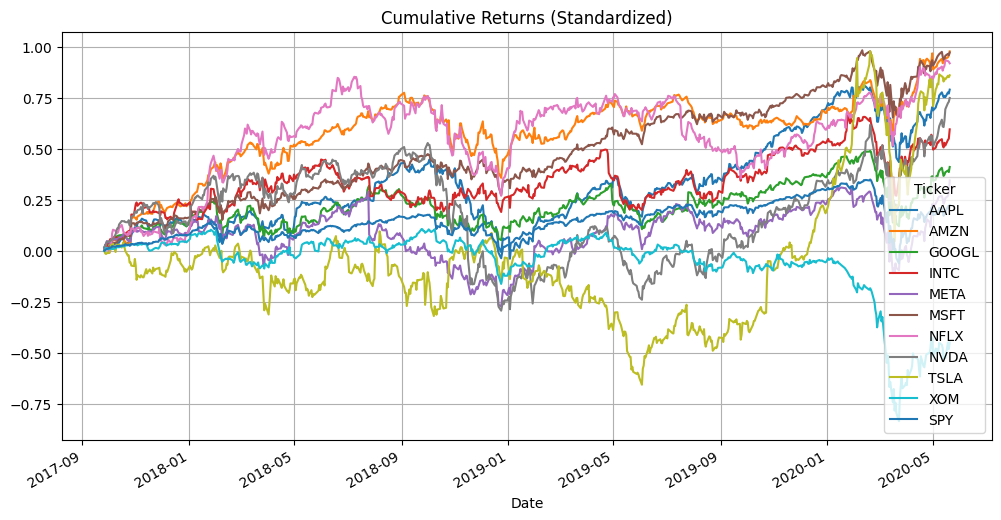

In [8]:
# --- Visualization ---
df_returns.cumsum().plot(figsize=(12, 6), title="Cumulative Returns (Standardized)")
plt.grid(True)
plt.show()

# ✅ Output: 'returns_scaled.csv' ready for use in training the trading agents.